# Team Members:
| Name | ID | 
|----------|----------|
| Ahmed nezar  | 21P0025  |
| Seif Yasser  | 21P0102  |
| Kirollos Ehab  | 21P0006  |
| AbdulRahman Hesham  | 21P0153  |
| Mohammed Yasser  | 210xxxx  |
| Omar Ahmed  | 22Pxxxx  |

# IMPORTS

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from scipy.stats import zscore

In [277]:
DATA_DIR='dataset.csv'

In [278]:
RUN_DIR = "."

In [279]:
class Utils:
    preprocessor_config = {
        "Normalizer": "MinMaxScaler",
        "Encoder": "OneHotEncoder",
        "excls_cols": ["CustomerID"],
        "categorical_cols": ['Gender'],
        "numerical_cols": ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
        # "Imputer": "SimpleImputer",
        # "Imputer_strategy": "mean",
    }

    @classmethod
    def create_directories(self, run_dir: str):
        self.log_dir = os.path.join(run_dir, "logs")
        self.data_path = "dataset.csv"
        self.model_dir = os.path.join(self.log_dir, "models")
        self.plot_dir = os.path.join(self.log_dir, "plots")
        self.raw_plots_dir = os.path.join(self.plot_dir, "raw")
        self.iqr_plots_dir = os.path.join(self.plot_dir, "iqr")
        self.zscore_plots_dir = os.path.join(self.plot_dir, "zscore")
        self.iqr_zscore_plots_dir = os.path.join(self.plot_dir, "iqr_zscore")

        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.plot_dir, exist_ok=True)
        os.makedirs(self.raw_plots_dir, exist_ok=True)
        os.makedirs(self.iqr_plots_dir, exist_ok=True)
        os.makedirs(self.zscore_plots_dir, exist_ok=True)
        os.makedirs(self.iqr_zscore_plots_dir, exist_ok=True)
        # print(f"Created directories: {self.log_dir}, {self.data_path}, {self.model_dir}")

    @classmethod
    def load_data(self):
        """
        Load the dataset from the specified path in the configuration.
        Returns:
            pd.DataFrame: The dataset.
        """
        return pd.read_csv(self.data_path)
    
    @classmethod
    def get_dir(self):
        return self.log_dir, self.model_dir, self.plot_dir 

In [280]:
Utils.create_directories(run_dir=RUN_DIR)

In [281]:
data = Utils.load_data()

In [282]:
# Change the configuration here (if needed)
Utils.preprocessor_config["Normalizer"] = "MinMaxScaler"
Utils.preprocessor_config["Encoder"] = "LabelEncoder"

# EDA

In [283]:
print("Dataset has ",data.shape[0]," rows and ",data.shape[1]," columns")
print("Columns are: ",list(data.columns))

Dataset has  200  rows and  5  columns
Columns are:  ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [284]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [285]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [286]:
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

> **🤔Conclusion:** No Missing values in the Dataset

In [287]:
data.duplicated().sum()

0

> **🤔Conclusion:** No Duplicate rows in the Dataset

In [288]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


# Preprocessing

In [289]:
class LogNormalizer():
    def _Log_Normalize(self, X):
        """
        Apply log normalization to the input data.

        This method takes an input array `X` and applies log normalization to it.
        The transformation is defined as sign(X) * log(abs(X) + 1), which helps in
        handling both positive and negative values and reducing the impact of large
        outliers.

        Parameters:
        X (numpy.ndarray): The input data array to be normalized.

        Returns:
        numpy.ndarray: The log-normalized data array.
        """
        return np.sign(X)*np.log(np.abs(X)+1)

    def fit_transform(self, X):
        """
        Fits the preprocessor to the data and transforms it.

        Parameters:
        X (pd.Series or np.ndarray): The input data to be transformed. If a pandas Series is provided, it will be converted to a numpy array.

        Returns:
        np.ndarray: The transformed data after applying log normalization.
        """
        if isinstance(X, pd.Series):
            X = X.to_numpy().reshape(-1, 1)
        return self._Log_Normalize(X)


In [290]:
class Preprocessor:
    def __init__(self, dataset):
        """
        Initializes the Preprocessor class.

        Attributes:
            config (dict): Configuration settings for the preprocessor.
            dataset (pd.DataFrame): The dataset loaded from the specified CSV file.
        """
        self.config = Utils.preprocessor_config
        # self.dataset = pd.read_csv(Utils.data_path)
        self.dataset = dataset
        self.dataset= self.dataset.reset_index()
        # self.Cat_columns = []

    def preprocess(self):
        """
        Preprocess the dataset by performing the following steps:
        1. Drop columns specified in the configuration.
        2. Scale the dataset.
        3. Encode categorical variables.

        Returns:
            pd.DataFrame: The preprocessed dataset.
        """
        # self.__check_nulls()
        # self.__check_duplicates()
        self.__drop_cols(self.config["excls_cols"])
        # self.__rename()
        # self.dataset = self.dataset.drop(columns=self.config["excls_cols"])
        if self.config["Normalizer"] and self.config["Normalizer"] != "None":
            self.__scale()
        self.__encode()
        return self.dataset

    def __drop_cols(self, col_list):
        """
        Drops specified columns from the dataset.
        Parameters:
        - col_list (list): List of column names to be dropped from the dataset.

        Returns:
            None
        """
        self.dataset = self.dataset.drop(columns=col_list)

    def __rename(self):
        """
        Renames specific columns in the dataset for consistency and ease of use.

        The following columns are renamed:
        - 'Annual Income (k$)' to 'Annual_Income'
        - 'Spending Score (1-100)' to 'Spending_Score'

        Returns:
            None
        """
        self.dataset = self.dataset.rename(columns={'Annual Income (k$)': 'Annual_Income',
                                                    'Spending Score (1-100)': 'Spending_Score'})

    def __scale(self):
        """
        Scales the numerical columns of the dataset based on the specified normalizer in the configuration.
        The method supports three types of normalizers:
        - MinMaxScaler: Scales features to a given range, usually between 0 and 1.
        - StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
        - LogNormalizer: Custom normalizer that applies a logarithmic transformation.
        Raises:
            ValueError: If the specified normalizer in the configuration is not supported.
        Note:
            The columns specified in the configuration under "categorical_cols" are excluded from scaling.
        """
        if self.config["Normalizer"] == "MinMaxScaler":
            from sklearn.preprocessing import MinMaxScaler
            normalizer = MinMaxScaler()

        elif self.config["Normalizer"] == "StandardScaler":
            from sklearn.preprocessing import StandardScaler
            normalizer = StandardScaler()

        elif self.config["Normalizer"] == "LogNormalizer":
            # from src.preprocessing.preprocessor import LogNormalizer
            normalizer = LogNormalizer()

        else:
            raise ValueError(
                "Normalizer not supported, please choose from MinMaxScaler, StandardScaler or LogNormalizer")

        for col in self.dataset.columns:
            if col not in self.config["categorical_cols"]:
                self.dataset[col] = normalizer.fit_transform(
                    self.dataset[[col]])

    def __encode(self):
        """
        Encodes categorical columns in the dataset based on the specified encoder in the configuration.
        This method supports two types of encoders:
        1. OneHotEncoder: Converts categorical variables into a series of binary columns.
        2. LabelEncoder: Converts categorical variables into numeric labels.
        Raises:
            ValueError: If the specified encoder in the configuration is not supported.
        Note:
            The configuration dictionary (`self.config`) must contain:
            - "Encoder": A string specifying the encoder type ("OneHotEncoder" or "LabelEncoder").
            - "categorical_cols": A list of column names that are categorical and need encoding.
        Example:
            config = {
                "Encoder": "OneHotEncoder",
                "categorical_cols": ["gender", "country"]
            }
        """
        if self.config["Encoder"] == "OneHotEncoder":
            from sklearn.preprocessing import OneHotEncoder
            encoder = OneHotEncoder()
            for col in self.dataset.columns:
                if col in self.config["categorical_cols"]:
                    self.dataset = pd.get_dummies(
                        self.dataset, columns=[col], dtype=int)

        elif self.config["Encoder"] == "LabelEncoder":
            from sklearn.preprocessing import LabelEncoder
            encoder = LabelEncoder()
            for col in self.dataset.columns:
                if col in self.config["categorical_cols"]:
                    self.dataset[col] = encoder.fit_transform(
                        self.dataset[col])
        else:
            raise ValueError(
                "Encoder not supported, please choose from OneHotEncoder or LabelEncoder")

    def __check_nulls(self):
        """
        Checks for null values in the dataset.

        This method checks if there are any null values in the dataset. If null values are found,
        it prints "Nulls imputed". Otherwise, it prints "No nulls found".
        """
        if self.dataset.isnull().sum().sum() > 0:
            # self.__impute()
            print("Nulls imputed")
        else:
            print("No nulls found")

    def __check_duplicates(self):
        """
        Check for and remove duplicate rows in the dataset.

        This method checks if there are any duplicate rows in the dataset. If duplicates are found,
        they are removed, and a message indicating that duplicates were removed is printed. If no
        duplicates are found, a message indicating that no duplicates were found is printed.

        Returns:
            None
        """
        if self.dataset.duplicated().sum() > 0:
            self.dataset = self.dataset.drop_duplicates()
            print("Duplicates removed")
        else:
            print("No duplicates found")


In [291]:
preprocessor = Preprocessor(data)
data_preprocessed = preprocessor.preprocess()

# Outlier Detection

In [292]:
class OutlierRemoval:
    def __init__(self, dataset):
        """
        Initializes the OutlierRemoval class.

        Parameters:
            dataset (pd.DataFrame): The dataset to process for outlier removal.
        """
        self.dataset = dataset.copy()
        self.dataset=self.dataset.set_index('CustomerID')

    def detect_outliers_IQR(self):
        """
        Detects outliers in numerical columns using the IQR method.
        Adds new columns indicating outliers for each numerical column.
        """
        for col in self.dataset.select_dtypes(include=np.number).columns:
            Q1 = self.dataset[col].quantile(0.25)
            Q3 = self.dataset[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            self.dataset[f'OUTLIER_IQR_{col}'] = (
                (self.dataset[col] < lower_bound) | (self.dataset[col] > upper_bound)
            )
        return self.dataset

    def detect_outliers_zscore(self, threshold=3):
        """
        Detects outliers in numerical columns using the Z-score method.
        Adds new columns indicating outliers for each numerical column.

        Parameters:
            threshold (float): The Z-score threshold to flag outliers.
        """
        numerical_data = self.dataset.select_dtypes(include=np.number)
        z_scores = pd.DataFrame(zscore(numerical_data), columns=numerical_data.columns, index=self.dataset.index)

        for col in z_scores.columns:
            self.dataset[f'OUTLIER_ZSCORE_{col}'] = (np.abs(z_scores[col]) > threshold)

        return self.dataset

    def remove_outliers_IQR(self):
        """
        Removes outliers detected by the IQR method.
        Equivalent to the standalone `outliers_removal_IQR` function.
        """
        # Detect outliers using IQR
        self.detect_outliers_IQR()
        
        # Find all columns starting with "OUTLIER"
        outliers_columns = [col for col in self.dataset.columns if col.startswith("OUTLIER")]
        
        # Filter out rows with any IQR-based outliers
        outlier_cols = [col for col in self.dataset.columns if col.startswith("OUTLIER_IQR")]
        self.dataset = self.dataset[~self.dataset[outlier_cols].any(axis=1)]
        
        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors='ignore')
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')
        
        return self.dataset


    def remove_outliers_zscore(self, zscore_threshold=3):
        """
        Removes outliers detected by the Z-score method.
        Equivalent to the standalone `outliers_removal_zscore` function.

        Parameters:
            zscore_threshold (float): The Z-score threshold to flag outliers.
        """
        # Detect outliers using Z-score
        self.detect_outliers_zscore(threshold=zscore_threshold)
        
        # Find all columns starting with "OUTLIER"
        outliers_columns = [col for col in self.dataset.columns if col.startswith("OUTLIER")]
        
        # Filter out rows with any Z-score-based outliers
        outlier_cols = [col for col in self.dataset.columns if col.startswith("OUTLIER_ZSCORE")]
        self.dataset = self.dataset[~self.dataset[outlier_cols].any(axis=1)]
        
        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors='ignore')
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')
        
        return self.dataset

    def remove_outliers_zscore_IQR(self, zscore_threshold=3):
        """
        Removes outliers detected by both IQR and Z-score methods.
        Equivalent to the standalone `outliers_removal_zscore_IQR` function.

        Parameters:
            zscore_threshold (float): The Z-score threshold to flag outliers.
        """
        # Detect outliers using both IQR and Z-score methods
        self.detect_outliers_IQR()
        self.detect_outliers_zscore(threshold=zscore_threshold)

        # Find all columns starting with "OUTLIER"
        outliers_columns = [col for col in self.dataset.columns if col.startswith("OUTLIER")]

        # Filter out rows with any outliers
        self.dataset = self.dataset[~self.dataset[outliers_columns].any(axis=1)]

        # Drop all "OUTLIER" columns and the 'CustomerID' column
        self.dataset.drop(columns=outliers_columns, inplace=True, errors='ignore')
        # self.dataset.drop(columns=['CustomerID'], inplace=True, errors='ignore')

        return self.dataset

# Visualization

In [293]:
class Plotter:
    figures=[]
    @staticmethod
    def init(dir:str='raw'):
        Plotter.seaborn_palette()
        _, _, plot_dir = Utils.get_dir()
        plot_dir=os.path.join(plot_dir, dir)
        return plot_dir
    
    @staticmethod
    def seaborn_palette(palette: str = 'Set2'):
        sns.set_palette(palette)

    @classmethod
    def hitogram_plot(self,data, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.histplot(data, x=key, bins=3, hue=key, multiple="stack")
        plt.title(f"Distribution of {key}")
        plt.xlabel(key)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"hitogram_plot_{key}.png"))
        self.figures.append(os.path.join(plot_dir,f"hitogram_plot_{key}.png"))
        plt.close() 
        
    @classmethod
    def pie_chart_plot(self,data, key, plot_dir):
        plt.figure(figsize=(10, 6))
        data[key].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(f"Distribution of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"pie_chart_plot_{key}.png"))
        self.figures.append(os.path.join(plot_dir,f"pie_chart_plot_{key}.png"))
        plt.close()
    
    @classmethod
    def scatteplot(self,df, x, y, plot_dir, hue = None):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x=x, y=y, hue=hue)
        plt.title(f"{x} vs {y}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"scatterplot_{x}_{y}.png"))
        self.figures.append(os.path.join(plot_dir,f"scatterplot_{x}_{y}.png"))
        plt.close()
    
    @classmethod
    def categorical_boxplot(self,df, x, y, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=x, y=y, hue=y)
        plt.title(f"{x} vs {y}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"categorical_boxplot_{x}_{y}.png"))
        self.figures.append(os.path.join(plot_dir,f"categorical_boxplot_{x}_{y}.png"))
        plt.close()

    @classmethod 
    def continuous_boxplot(self,df, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[key])
        plt.title(f"Box plot of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"continuous_boxplot_{key}.png"))
        self.figures.append(os.path.join(plot_dir,f"continuous_boxplot_{key}.png"))
        plt.close()
    
    @classmethod
    def normal_distribution_plot(self,df, key, plot_dir):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(df[key], fill=True, color='blue')
        plt.grid(True)
        plt.title(f"Normal distribution of {key}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"normal_distribution_plot_{key}.png")) 
        self.figures.append(os.path.join(plot_dir,f"normal_distribution_plot_{key}.png"))
        plt.close()
    
    @classmethod
    def violin_swarm_plot(self,df, x, y, hue, plot_dir, plot_type='violin'):
        plt.figure(figsize=(10, 6))
        if plot_type == 'violin':
            sns.violinplot(data=df, x=x, y=y, hue=hue)
        elif plot_type == 'swarm':
            sns.swarmplot(data=df, x=x, y=y, hue=hue)
        elif plot_type == 'both':
            sns.violinplot(data=df, x=x, y=y, hue=hue)
            sns.swarmplot(data=df, x=x, y=y, hue=hue, palette='dark:black')
        else:
            raise ValueError("Invalid plot type")
        plt.title(f"Violin Plot for {x}")
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, f"violin_swarm_plot{x}_{y}_{plot_type}.png"))
        self.figures.append(os.path.join(plot_dir,f"violin_swarm_plot{x}_{y}_{plot_type}.png"))
        plt.close()

        
    @classmethod
    def get_figures(self):
        return self.figures

In [311]:
class Monitor:
    
    @staticmethod
    def run(dataset,dir='raw'):
        plot_dir = Plotter.init(dir=dir)
        Plotter.figures=[]
        tasks = [
            (Plotter.hitogram_plot, [dataset, 'Gender', plot_dir]),
            (Plotter.pie_chart_plot, [dataset, 'Gender', plot_dir]),
            (Plotter.scatteplot, [dataset, 'Age', 'Annual Income (k$)', plot_dir], {'hue': 'Gender'}),
            (Plotter.scatteplot, [dataset, 'Age', 'Spending Score (1-100)', plot_dir], {'hue': 'Gender'}),
            (Plotter.scatteplot, [dataset, 'Annual Income (k$)', 'Spending Score (1-100)', plot_dir], {'hue': 'Gender'}),
            (Plotter.categorical_boxplot, [dataset, 'Annual Income (k$)', 'Gender', plot_dir]),
            (Plotter.categorical_boxplot, [dataset, 'Spending Score (1-100)', 'Gender', plot_dir]),
            (Plotter.continuous_boxplot, [dataset, 'Age', plot_dir]),
            (Plotter.continuous_boxplot, [dataset, 'Annual Income (k$)', plot_dir]),
            (Plotter.continuous_boxplot, [dataset, 'Spending Score (1-100)', plot_dir]),
            (Plotter.normal_distribution_plot, [dataset, 'Age', plot_dir]),
            (Plotter.normal_distribution_plot, [dataset, 'Annual Income (k$)', plot_dir]),
            (Plotter.normal_distribution_plot, [dataset, 'Spending Score (1-100)', plot_dir]),
            (Plotter.violin_swarm_plot, [dataset, 'Age', 'Gender'], {'hue': 'Gender', 'plot_type': 'both', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Annual Income (k$)', 'Gender'], {'hue': 'Gender', 'plot_type': 'both', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Spending Score (1-100)', 'Gender'], {'hue': 'Gender', 'plot_type': 'both', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Age', 'Gender'], {'hue': 'Gender', 'plot_type': 'swarm', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Annual Income (k$)', 'Gender'], {'hue': 'Gender', 'plot_type': 'swarm', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Spending Score (1-100)', 'Gender'], {'hue': 'Gender', 'plot_type': 'swarm', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Age', 'Gender'], {'hue': 'Gender', 'plot_type': 'violin', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Annual Income (k$)', 'Gender'], {'hue': 'Gender', 'plot_type': 'violin', 'plot_dir': plot_dir}),
            (Plotter.violin_swarm_plot, [dataset, 'Spending Score (1-100)', 'Gender'], {'hue': 'Gender', 'plot_type': 'violin', 'plot_dir': plot_dir}),

        ]
        
        # Execute tasks with progress tracking
        for task in tqdm(tasks, desc="Generating plots", unit="plot"):
            func = task[0]  # Extract the function
            args = task[1]  # Extract the positional arguments
            kwargs = task[2] if len(task) > 2 else {}  # Extract keyword arguments (if any)
            
            func(*args, **kwargs)
        figures=Plotter.get_figures()
        for fig in tqdm(figures, desc="Generating plots", unit="plot"):
            img = plt.imread(fig)
            plt.imshow(img)
            # print(fig)
            plt.show()
        # plt.close()
        print("Plots generated successfully")


## Raw Dataset

Generating plots:   0%|          | 0/22 [00:00<?, ?plot/s]

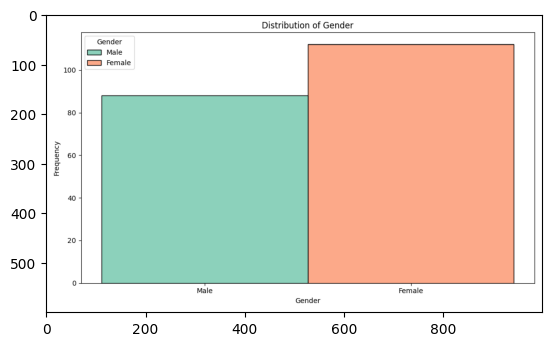

Generating plots:   5%|▍         | 1/22 [00:00<00:02,  7.32plot/s]

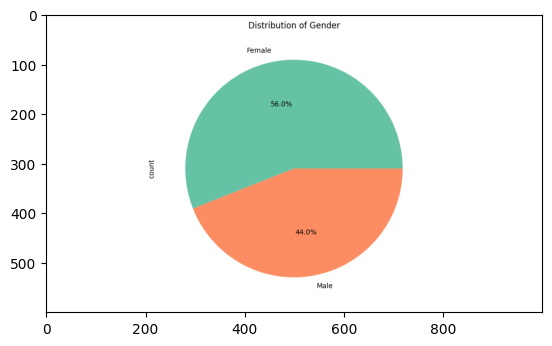

Generating plots:   9%|▉         | 2/22 [00:01<00:12,  1.61plot/s]

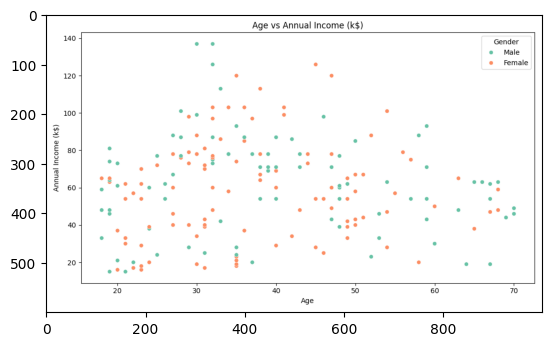

Generating plots:  14%|█▎        | 3/22 [00:01<00:08,  2.35plot/s]

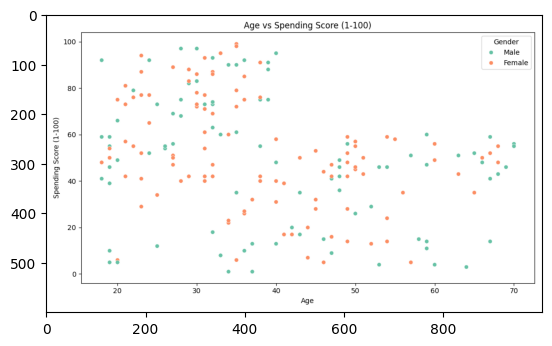

Generating plots:  18%|█▊        | 4/22 [00:01<00:05,  3.15plot/s]

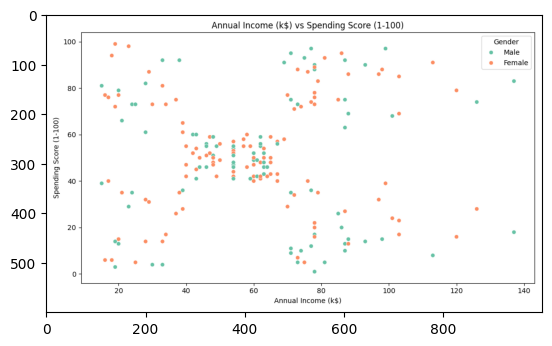

Generating plots:  23%|██▎       | 5/22 [00:01<00:04,  3.90plot/s]

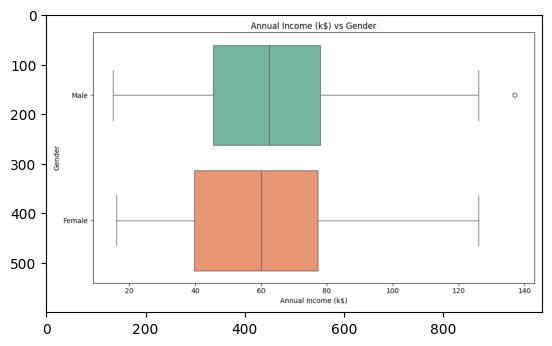

Generating plots:  27%|██▋       | 6/22 [00:01<00:03,  4.63plot/s]

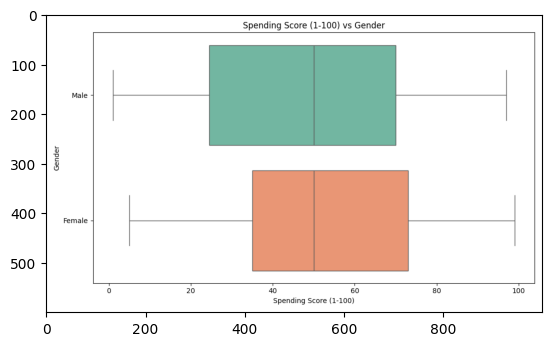

Generating plots:  32%|███▏      | 7/22 [00:01<00:02,  5.20plot/s]

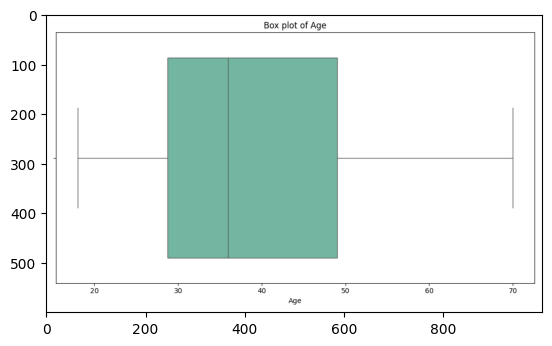

Generating plots:  36%|███▋      | 8/22 [00:02<00:02,  5.63plot/s]

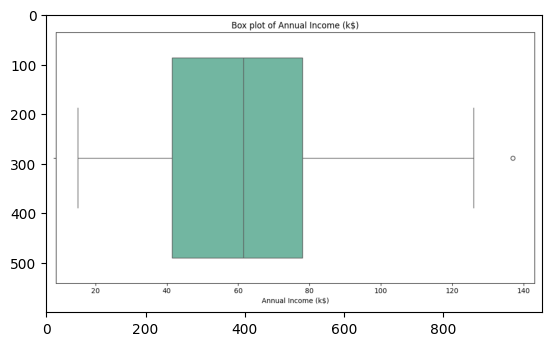

Generating plots:  41%|████      | 9/22 [00:02<00:02,  6.00plot/s]

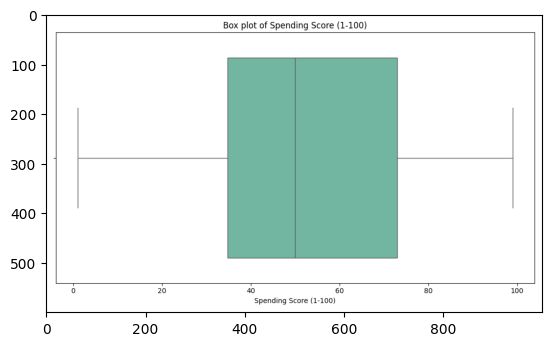

Generating plots:  45%|████▌     | 10/22 [00:02<00:01,  6.31plot/s]

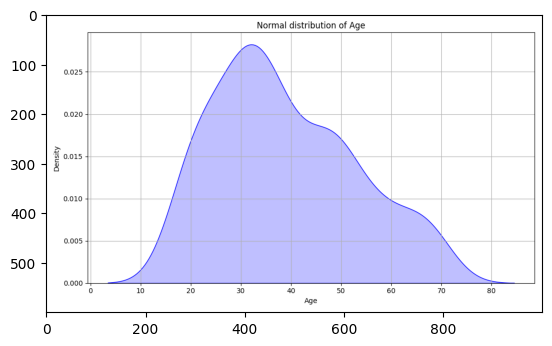

Generating plots:  50%|█████     | 11/22 [00:02<00:01,  6.20plot/s]

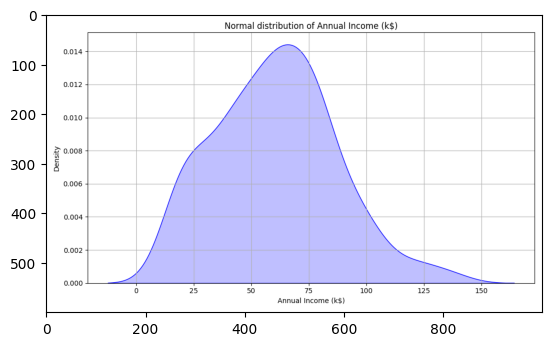

Generating plots:  55%|█████▍    | 12/22 [00:02<00:01,  6.41plot/s]

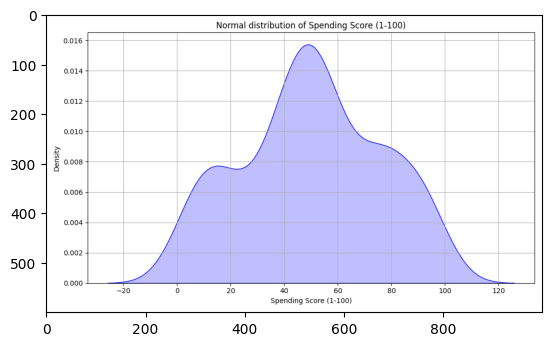

Generating plots:  59%|█████▉    | 13/22 [00:02<00:01,  6.49plot/s]

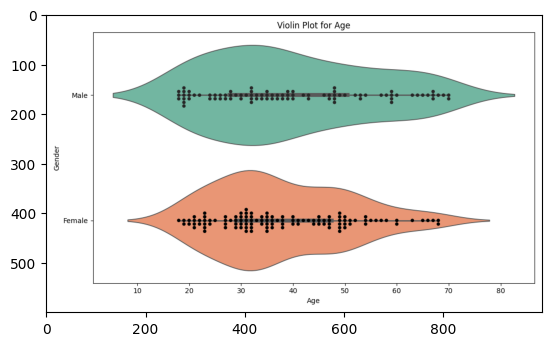

Generating plots:  64%|██████▎   | 14/22 [00:02<00:01,  6.32plot/s]

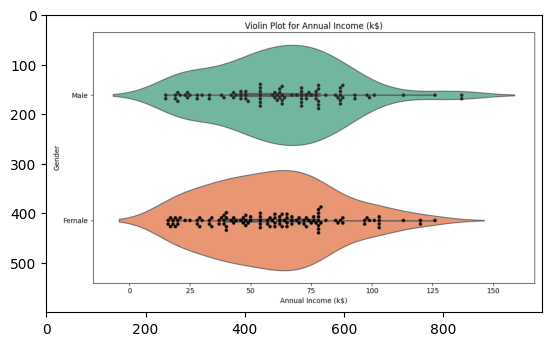

Generating plots:  68%|██████▊   | 15/22 [00:03<00:01,  6.28plot/s]

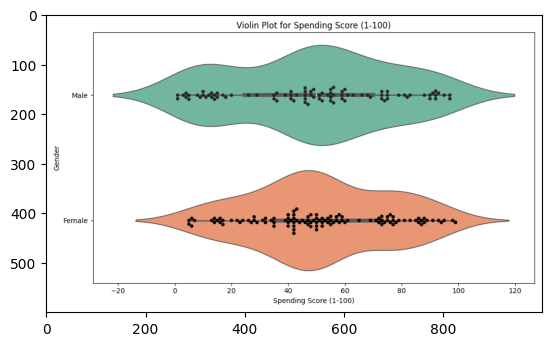

Generating plots:  73%|███████▎  | 16/22 [00:03<00:00,  6.32plot/s]

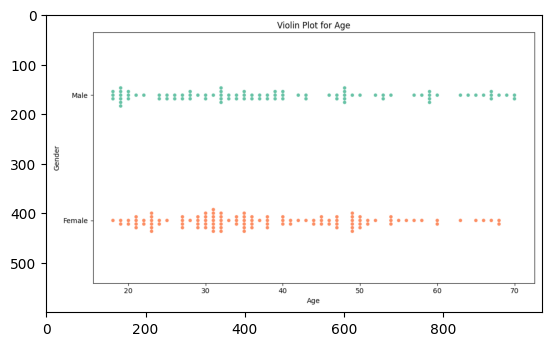

Generating plots:  77%|███████▋  | 17/22 [00:03<00:00,  6.30plot/s]

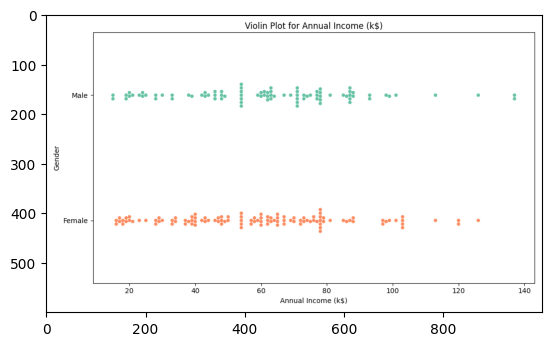

Generating plots:  82%|████████▏ | 18/22 [00:03<00:00,  6.47plot/s]

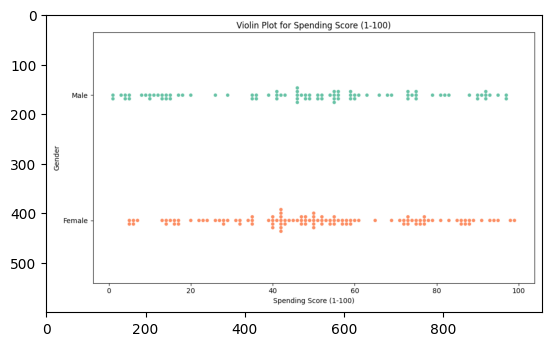

Generating plots:  86%|████████▋ | 19/22 [00:03<00:00,  6.48plot/s]

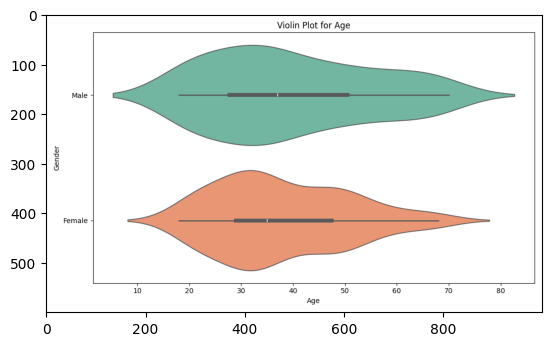

Generating plots:  91%|█████████ | 20/22 [00:03<00:00,  6.33plot/s]

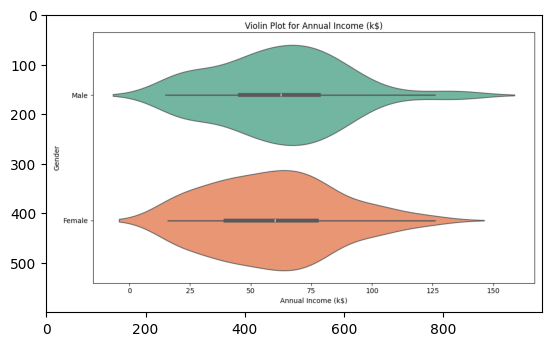

Generating plots:  95%|█████████▌| 21/22 [00:04<00:00,  6.46plot/s]

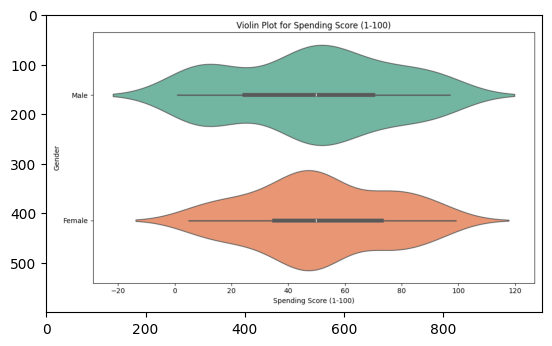

Generating plots: 100%|██████████| 22/22 [00:04<00:00,  5.28plot/s]

Plots generated successfully


In [312]:
Monitor.run(data,dir='raw')

## Outliers Removed

In [296]:
outlierremoval=OutlierRemoval(data)

### IQR

In [297]:
data_outliers_removed_IQR=outlierremoval.remove_outliers_IQR()

In [298]:
data_outliers_removed_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
194,Female,38,113,91
195,Female,47,120,16
196,Female,35,120,79


In [299]:
# Monitor.run(data_preprocessed_IQR,dir='iqr')

In [300]:
preprocessor = Preprocessor(data_outliers_removed_IQR)
data_preprocessed_IQR = preprocessor.preprocess()
data_preprocessed_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


### Z-Score

In [301]:
data_outliers_removed_zscore=outlierremoval.remove_outliers_zscore()

In [302]:
# Monitor.run(data_outliers_removed_zscore,dir='zscore')

In [303]:
preprocessor = Preprocessor(data_outliers_removed_zscore)
data_preprocessed_zscore = preprocessor.preprocess()
data_preprocessed_zscore

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510


### IQR and Z-Score

In [304]:
data_outliers_removed_zscore_IQR=outlierremoval.remove_outliers_zscore_IQR()

In [305]:
# Monitor.run(data_outliers_removed_zscore_IQR,dir='iqr_zscore')

In [306]:
preprocessor = Preprocessor(data_outliers_removed_zscore_IQR)
data_preprocessed_zscore_IQR = preprocessor.preprocess()
data_preprocessed_zscore_IQR

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0.019231,0.000000,0.387755
1,1,0.057692,0.000000,0.816327
2,0,0.038462,0.009009,0.051020
3,0,0.096154,0.009009,0.775510
4,0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0,0.384615,0.882883,0.918367
194,0,0.557692,0.945946,0.153061
195,0,0.326923,0.945946,0.795918
196,0,0.519231,1.000000,0.275510
